# BACI data files explained
<i>Maxim Chernetskiy, Mathias Disney 2018<br>
WP2 Consistent EO datasets across space, time and wavelength</i>
<br><br><br>
This document explains basics of opening and manipulation of the BACI Surface State Vector (SSV) files in netCDF format. SSV consists of surface reflectance, albedo, land surface temperature (LST) and synthetic apperture radar (SAR) backscatter. All datasets have the same spatial resolution, geographical projection and temporal step. Presented examples are based on the following python 2.7 libraries:<br>
    netCDF4 - working with python netCDF;<br>
    GDAL - Geospatial Data Abstraction Library;<br>
    seaborn - enhanced data visualization and<br>
    scikit-learn - machine learning library.<br>
    
Datasets can be found in the CEDA archive <i>/neodc/baci_ssv/data/v1.0/</i><br>
You can find more information on these data sets in the CEDA catalogue <a href="https://catalogue.ceda.ac.uk/uuid/1452fa13390549f5a6794840b948a8d1 "
All regional sites which are in the geographical Europe are in the same folder <i>/group_workspaces/jasmin2/baci/sigil/baci_wp2_files/13_europe/</i><br>
Datasets are in sinusoidal projection and divided by MODIS tiles <a href="https://modis-land.gsfc.nasa.gov/MODLAND_grid.html">https://modis-land.gsfc.nasa.gov/MODLAND_grid.html</a>
This means that processed regions are larger than BACI regional sites.
<br>
Table of Contents:
<br>
    1. Opening and reading
    1.1 Optical data
    1.2 Land Surface Temperature (LST)
    1.3 Synthetic Apperture Radar (SAR) backscatter
    2. Reprojection
    3. Principal Componenet Analysis (PCA)
    4. Clustering
    4.1 Red and NIR
    4.2 Red, NIR and LST
    4.3 Red, NIR, LST and micowave

In [1]:
# Import the required packages
import os
# Change working directory to top of the repository at ~/ceda-notebooks/
os.chdir('../../..')

%matplotlib inline
import numpy as np
import gdal
import netCDF4 as nc
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scripts import grid_lines
from scripts.utils import venv_utils
import sklearn.decomposition as decomp
import sklearn.preprocessing as prep
from sklearn.cluster import KMeans

# Create venv and install additional packages
venv_utils.setup_venv(
    venv_name='venv_notebook',
    packages=[
        'OSR',
    ]
)
import osr

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
print("nice day")

Venv already exists: /home/users/mr1333/nb-venvs/venv_notebook
force_recreate must be True to recreate a venv
Activating virtualenv: venv_notebook
Installing package: OSR


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pyglet-1.1.4-py3-none-any.whl
  Using cached eyeD3-0.9.6-py3-none-any.whl (245 kB)
  Using cached filetype-1.0.10-py2.py3-none-any.whl (16 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached coverage-5.5-cp38-cp38-manylinux2010_x86_64.whl (245 kB)
  Created wheel for OSR: filename=OSR-0.0.1-py3-none-any.whl size=5648 sha256=6f060812442310f5f137a48bdfe172e200f4135a3aedba249c3afe2155023e79
  Stored in directory: /home/users/mr1333/.cache/pip/wheels/2b/b3/07/a8da62a675b30ce8b33ed87559ded8900845153a8b3cc784dd
Successfully built OSR
nice day


In [2]:
sns.set()

## 1. Opening and reading
### 1.1 Optical data

First, open a netcdf file with the netCDF4 library function Dataset() which opens file returns a netcdf dataset. You have to specify your own path to the data!

In [3]:
ds = nc.Dataset('/neodc/baci_ssv/data/v1.0/regional_sites/13_europe/optical/rho_h18v04_2015_7day.nc')
print("got my file now")

got my file now


Now let's see what is inside the dataset

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: NBAR reflectance and BB albedo
    dimensions(sizes): x(1200), y(1200), day(49), band(7), str_dim(10)
    variables(dimensions): |S1 date_str(day, str_dim), int32 julday(day), float32 lat(x, y), float32 lon(x, y), |S1 crs()
    groups: reflectance, albedo


We can see some variables and two groups: reflectance and albedo. The meaning of groups is combining some variables together in order to make netcdf more structured. Now let's examine the variables. <br>
Dates are represented as julian dates which are days since January 1, 4713 BC. If we print the variable:

In [5]:
print(ds['julday'][:])

[2457030 2457037 2457044 2457051 2457058 2457065 2457072 2457079 2457086
 2457093 2457100 2457107 2457114 2457121 2457128 2457135 2457142 2457149
 2457156 2457163 2457170 2457177 2457184 2457191 2457198 2457205 2457212
 2457219 2457226 2457233 2457240 2457247 2457254 2457261 2457268 2457275
 2457282 2457289 2457296 2457303 2457310 2457317 2457324 2457331 2457338
 2457345 2457352 2457359 2457366]


So we see that almost two and half million days are passed since starting date <br>
This form of representation is usefull but not super convinient for humans. So we can convert julian days to "normal" date format

In [6]:
import matplotlib.dates as dates
date_arr = []
for jd in ds['julday'][:]: 
    date_arr.append(dates.num2date(dates.julian2num(jd)).date())
date_arr = np.array(date_arr)
print([d.isoformat() for d in date_arr])

['2015-01-07', '2015-01-14', '2015-01-21', '2015-01-28', '2015-02-04', '2015-02-11', '2015-02-18', '2015-02-25', '2015-03-04', '2015-03-11', '2015-03-18', '2015-03-25', '2015-04-01', '2015-04-08', '2015-04-15', '2015-04-22', '2015-04-29', '2015-05-06', '2015-05-13', '2015-05-20', '2015-05-27', '2015-06-03', '2015-06-10', '2015-06-17', '2015-06-24', '2015-07-01', '2015-07-08', '2015-07-15', '2015-07-22', '2015-07-29', '2015-08-05', '2015-08-12', '2015-08-19', '2015-08-26', '2015-09-02', '2015-09-09', '2015-09-16', '2015-09-23', '2015-09-30', '2015-10-07', '2015-10-14', '2015-10-21', '2015-10-28', '2015-11-04', '2015-11-11', '2015-11-18', '2015-11-25', '2015-12-02', '2015-12-09']


The next couple of variables are latitude and longitude

In [7]:
print(ds['lat'])
print (ds['lon'])

<class 'netCDF4._netCDF4.Variable'>
float32 lat(x, y)
    units: latitude
unlimited dimensions: 
current shape = (1200, 1200)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(x, y)
    units: longitude
unlimited dimensions: 
current shape = (1200, 1200)
filling on, default _FillValue of 9.969209968386869e+36 used


We can see that geographical coordinates are saved as two dimensional arrays with 1200X1200 pixels in each. If it's 2D array we can show an image of it

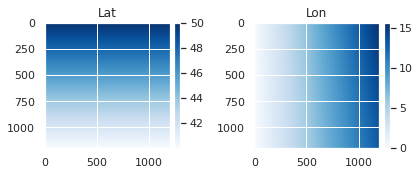

In [8]:
plt.subplot(121)
plt.title('Lat')
# This the main function in showing an image. Imshow - image show. Here it simply shows a 2D array.
plt.imshow(ds['lat'], cmap = plt.set_cmap('Blues'))
plt.colorbar(fraction=0.046, pad=0.03)

plt.subplot(122)
plt.title('Lon')
plt.imshow(ds['lon'])
plt.colorbar(fraction=0.046, pad=0.03)

plt.tight_layout()

The last variable with out group is CRS which is a representation of geographical projection.

In [9]:
print(ds['crs'])

<class 'netCDF4._netCDF4.Variable'>
|S1 crs()
    grid_mapping_name: latitude_longitude
    longitude_of_prime_meridian: 0.0
    semi_major_axis: 
    inverse_flattening: 
    spatial_ref: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]
    GeoTransform: [ 0.00000000e+00  9.26625433e+02  0.00000000e+00  5.55975260e+06
  0.00000000e+00 -9.26625433e+02]
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of   used


The groups 'reflectance' and 'albedo' are the combination of variables which relate to reflectance and albedo. This is the main thing in the datasets.

In [10]:
print(ds['reflectance'])
print(ds['albedo'])

<class 'netCDF4._netCDF4.Group'>
group /reflectance:
    description: Normalized at nadir (NBAR) reflectance
    dimensions(sizes): 
    variables(dimensions): float32 refl_b1(day, x, y), float32 refl_b1_sd(day, x, y), float32 refl_b2(day, x, y), float32 refl_b2_sd(day, x, y), float32 refl_b3(day, x, y), float32 refl_b3_sd(day, x, y), float32 refl_b4(day, x, y), float32 refl_b4_sd(day, x, y), float32 refl_b5(day, x, y), float32 refl_b5_sd(day, x, y), float32 refl_b6(day, x, y), float32 refl_b6_sd(day, x, y), float32 refl_b7(day, x, y), float32 refl_b7_sd(day, x, y)
    groups: 
<class 'netCDF4._netCDF4.Group'>
group /albedo:
    description: Broad band (BB) albedo
    dimensions(sizes): 
    variables(dimensions): float32 albedo_vis(day, x, y), float32 albedo_nir(day, x, y), float32 albedo_swir(day, x, y), float32 albedo_vis_sd(day, x, y), float32 albedo_nir_sd(day, x, y), float32 albedo_swir_sd(day, x, y)
    groups: 


We see that varialbes in these groups have three dimentions i.e. date, x and y. The dimentionality of the variables:

In [11]:
print (ds['reflectance/refl_b2'])

<class 'netCDF4._netCDF4.Variable'>
float32 refl_b2(day, x, y)
    units: surface bidirectional reflectance, band 2
path = /reflectance
unlimited dimensions: 
current shape = (49, 1200, 1200)
filling on, default _FillValue of 9.969209968386869e+36 used


In this case the temporal step is seven days + we can have some missing data. So first dimention is equal to 49. If we look at variable 'julday':

In [12]:
print (ds['julday'])

<class 'netCDF4._netCDF4.Variable'>
int32 julday(day)
    units: Julian day
unlimited dimensions: 
current shape = (49,)
filling on, default _FillValue of -2147483647 used


Plot NIR band

Use interactive mode (%matplotlib notebook) to find coordinates

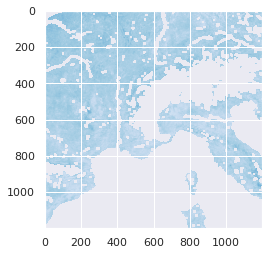

In [13]:
plt.imshow(ds['reflectance/refl_b2'][0,:,:])
plt.show()

Switch from interactive mode to normal show a point which was just found

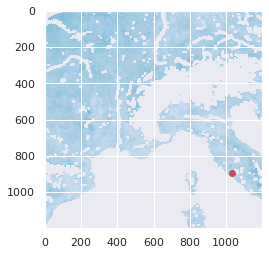

In [14]:

# ****************
x = 1033; y = 893
# ****************
plt.imshow(ds['reflectance/refl_b2'][0,:,:])
plt.plot(x, y, marker='o', color='r')

Show temporal prifile of the point. Note that in python arrays coordinate 'y' is the first dimension and 'x' the seond!

So the same size as the first dimention of reflectance. Therefore we can use it to plot temporal evelution of the data along with associated uncertainties:

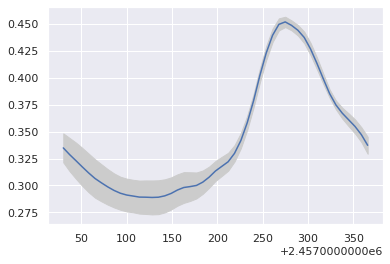

In [15]:
rho = ds['reflectance/refl_b2'][:, y, x]
rho_sd = ds['reflectance/refl_b2_sd'][:, y, x]

plt.fill_between(ds['julday'], rho + rho_sd, rho - rho_sd, color='0.8')
plt.plot(ds['julday'], rho)

Let's show seven reflectance bands for the first date

In [16]:
def plot_refl(var, vmin=0, vmax=1):
    plt.figure(figsize=(15, 5))
    for b in range(7):
        plt.subplot(2, 4, b + 1)
        plt.title('band %d' % (b+1))
        plt.imshow(ds[var % (b+1)][0,:,:], vmin=vmin, vmax=vmax, cmap=plt.set_cmap('gray'))
        plt.colorbar(fraction=0.046, pad=0.03)
        plt.axis('off')
    plt.tight_layout()

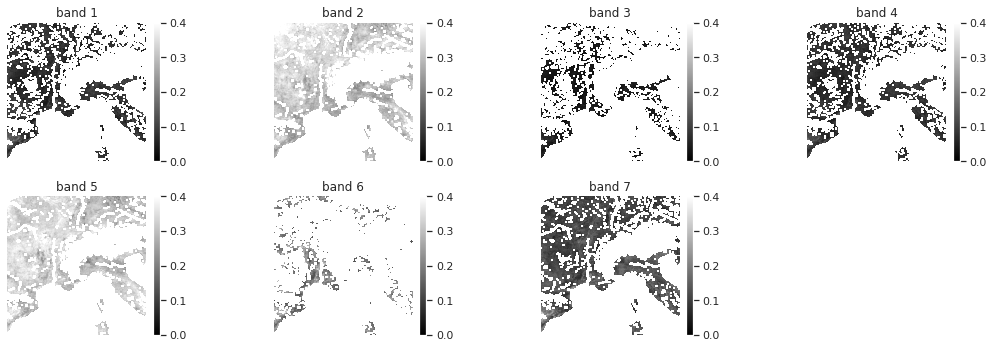

In [17]:
plot_refl('reflectance/refl_b%d', vmin=0, vmax=0.4)

In the same way we can show uncertainties in each band

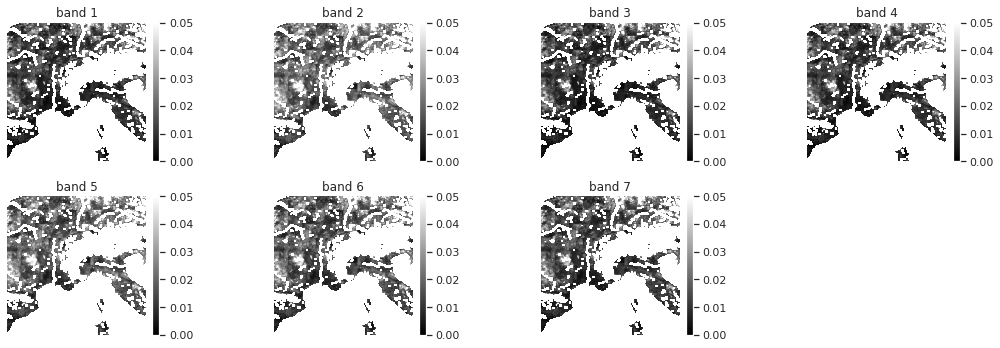

In [18]:
plot_refl('reflectance/refl_b%d_sd', vmin=0, vmax=0.05)

The group in the netcdf reflectance file is albedo.

In [19]:
def plot_albedo(var, vmin=0, vmax=1):
    plt.figure(figsize=(15, 5))
    bands = ['vis', 'nir', 'swir']
    for b in range(3):
        plt.subplot(2, 4, b + 1)
        plt.title('%s' % bands[b])
        plt.imshow(ds[var % bands[b]][0,:,:], vmin=vmin, vmax=vmax, cmap=plt.set_cmap('gray'))
        plt.colorbar(fraction=0.046, pad=0.03)
        plt.axis('off')
    plt.tight_layout()

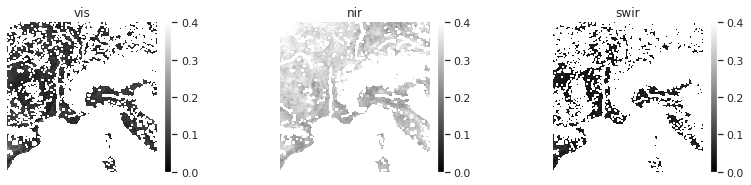

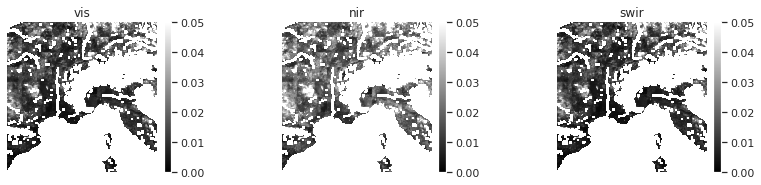

In [20]:
plot_albedo('albedo/albedo_%s', vmin=0, vmax=0.4)
plot_albedo('albedo/albedo_%s_sd', vmin=0, vmax=0.05)

We can show a RGB image as three dimentional array where each dimention is a color componenet. For example true color composite.

(-0.5, 1199.5, 1199.5, -0.5)

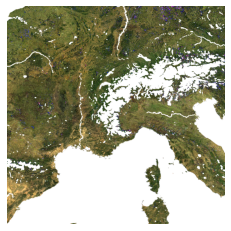

In [21]:
img_rgb = np.zeros((1200, 1200, 3))
img_rgb[:, :, 0] = ds['reflectance/refl_b1'][0,:,:] * 5
img_rgb[:, :, 1] = ds['reflectance/refl_b4'][0,:,:] * 5
img_rgb[:, :, 2] = ds['reflectance/refl_b3'][0,:,:] * 5
plt.imshow(img_rgb)
# plt.colorbar(fraction=0.046, pad=0.03)
plt.axis('off')

### 1.2 Land Surface Temperature (LST)
Open and show the LST dataset.

In [22]:
# ds_lst = nc.Dataset('/neodc/baci_ssv/data/v1.0/regional_sites/13_europe/lst/lst_h18v04_2015_7day.nc')
ds_lst = nc.Dataset('/neodc/baci_ssv/data/v1.0/regional_sites/13_europe/lst/lst_h18v04_2015_7day.nc')
print(ds_lst)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): x(1200), y(1200), time(53)
    variables(dimensions): float64 x(x), float64 y(y), float64 lon(y, x), float64 lat(y, x), float64 lst(time, y, x), float64 lst_sd(time, y, x), float64 time(time), |S1 crs()
    groups: 


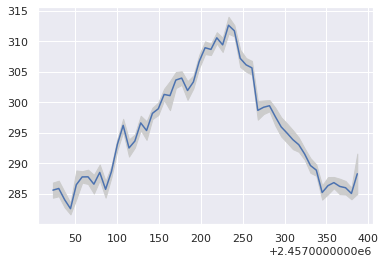

In [23]:
lst = ds_lst['lst'][:, y, x]
lst_sd = ds_lst['lst_sd'][:, y, x]

plt.fill_between(ds_lst['time'], lst + lst_sd, lst - lst_sd, color='0.8')
plt.plot(ds_lst['time'], lst)

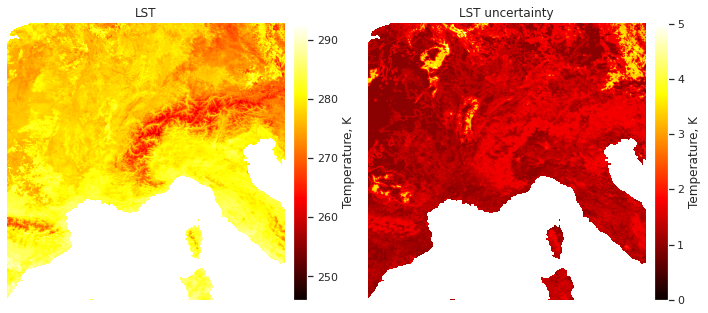

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('LST')
plt.imshow(ds_lst['lst'][0,:,:], cmap=plt.set_cmap('hot'))
plt.colorbar(fraction=0.046, pad=0.03, label='Temperature, K')
plt.axis('off')

plt.subplot(122)
plt.title('LST uncertainty')
plt.imshow(ds_lst['lst_sd'][0,:,:], vmin=0, vmax=5)
plt.colorbar(fraction=0.046, pad=0.03, label='Temperature, K')
plt.axis('off')

plt.tight_layout()

### 1.3 Synthetic Apperture Radar (SAR) backscatter

In [25]:
ds_sar = nc.Dataset('/neodc/baci_ssv/data/v1.0/regional_sites/13_europe/sar/sentinel-1_descending_h18v04_2015_7day_vv.nc')
print(ds_sar)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Smoothed Sentinel-1 backscatter with uncertainties
    dimensions(sizes): x(1200), y(1200), date(53)
    variables(dimensions): float32 bs(date, y, x), float32 bs_sd(date, y, x), float32 bs_orig(date, y, x), float32 bs_orig_sd(date, y, x), int32 julday(date), float32 lat(y, x), float32 lon(y, x), float64 x(x), float64 y(y)
    groups: 


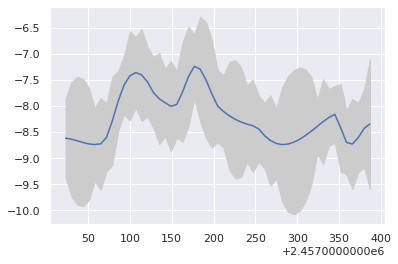

In [26]:
# x = 1000
# y = 800

sar = ds_sar['bs'][:, y, x]

sar_sd = ds_sar['bs_sd'][:, y, x]

plt.fill_between(ds_sar['julday'], sar + sar_sd, sar - sar_sd, color='0.8')
plt.plot(ds_sar['julday'], sar)

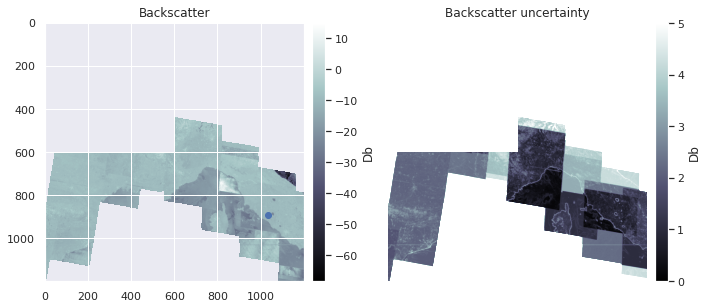

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Backscatter')
plt.imshow(ds_sar['bs'][0,:,:], cmap=plt.set_cmap('bone'))
plt.colorbar(fraction=0.046, pad=0.03, label='Db')
plt.plot(x, y, 'o')
# plt.axis('off')

plt.subplot(122)
plt.title('Backscatter uncertainty')
plt.imshow(ds_sar['bs_sd'][0,:,:], vmin=0, vmax=5)
plt.colorbar(fraction=0.046, pad=0.03, label='Db')
plt.axis('off')

plt.tight_layout()

## 2. Reprojection
<br><br>
BACI netCDF files are in the MODIS sinusoidal projection (SR-ORG:6842). Below we can see an example with grid lines.

In [28]:
def draw_geogrid(img, lat_max, lat_min, lon_max, lon_min, proj, geo):
    """
    Draw grid lines over an image
    """
    # Draw lat-lon grid lines
    for lon in range(lon_min, lon_max, 2):
        x1, y1 = grid_lines.get_pixels(geo, lat_max, lon)
        x2, y2 = grid_lines.get_pixels(geo, lat_min, lon)
        x1, x2, y1, y2 = grid_lines.find_inter(x1, x2, y1, y2, img.shape[0], img.shape[1])
        plt.plot([x1, x2], [y1, y2], c='k')
    for lat in range(lat_min, lat_max, 2):
        x1, y1 = grid_lines.get_pixels(geo, lat, lon_max)
        x2, y2 = grid_lines.get_pixels(geo, lat, lon_min)
        x1, x2, y1, y2 = grid_lines.find_inter(x1, x2, y1, y2, img.shape[0], img.shape[1])
        plt.plot([x1, x2], [y1, y2], c='k')

NotImplementedError: Wrong number or type of arguments for overloaded function 'CoordinateTransformation_TransformPoint'.
  Possible C/C++ prototypes are:
    OSRCoordinateTransformationShadow::TransformPoint(double [3])
    OSRCoordinateTransformationShadow::TransformPoint(double [4])
    OSRCoordinateTransformationShadow::TransformPoint(double [3],double,double,double)
    OSRCoordinateTransformationShadow::TransformPoint(double [4],double,double,double,double)


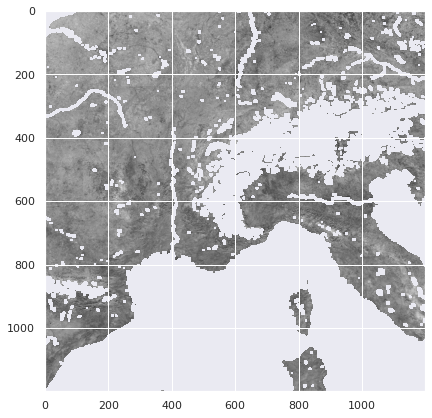

In [29]:
lat_max = np.max(ds['lat'])
lat_min = np.min(ds['lat'])
lon_min = np.min(ds['lon'])
lon_max = np.max(ds['lon'])

# Get projection and geo-transformation
crs_proj = ds['crs'].spatial_ref
crs_geo = ds['crs'].GeoTransform

# Get first date from the NIR reflectance band
# img = ds['reflectance/refl_b2'][0,:,:]

fig = plt.figure(figsize=(7, 7))
plt.imshow(ds['reflectance/refl_b2'][0,:,:], vmin=0, vmax=0.6, cmap=plt.set_cmap('gray'))

draw_geogrid(ds['reflectance/refl_b2'][0,:,:],
             np.round(lat_max).astype(int), 
             np.round(lat_min).astype(int), 
             np.round(lon_max).astype(int), 
             np.round(lon_min).astype(int), 
             crs_proj, crs_geo)

So we see that in sinusoidal projection geometry can't be described by 1D latitude and longitude vectors. Besides not all GIS software can recognize sinusoidal projection. An example is OpenLayers. In addition not all software can work well (or can't work  at all) with netCDF format. Therefore sometimes it's nesssary to reproject data to WGS 84 (lat-lon, EPSG:4326) and save result in some well known format such as GeoTiff.
<br><br>
For reprojection and geotiff we need library GDAL - Geospatial Data Abstraction Library

In [30]:
# Create empty output file
drv_out = gdal.GetDriverByName('GTiff')
ds_out = drv_out.Create('baci_wgs84.tif', 1200, 1250, 1, gdal.GDT_Float32)

# make output projection
wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
proj_out = wgs84.ExportToWkt()

# make geotransformation
lon_size = (lon_max - lon_min) / 1200.
lat_size = (lat_max - lat_min) / 1200.
# 0.01296 0.008
geo_out = (np.float(ds['lon'][0,0]), lon_size, 0, np.float(ds['lat'][0,0]), 0, -lat_size)

# Setup input geotrasnforamation and projection
ds_out.SetGeoTransform(geo_out)
ds_out.SetProjection(proj_out)

# Create input gdal dataset in memory
drv_in = gdal.GetDriverByName('MEM')
ds_in = drv_in.Create('', 1200, 1200, 1, gdal.GDT_Float32)

# Setup input geotrasnforamation and projection
ds_in.SetGeoTransform(crs_geo)
ds_in.SetProjection(str(crs_proj))

# Write an image from netCDF to input gdal dataset
ds_in.GetRasterBand(1).WriteArray(ds['reflectance/refl_b2'][0,:,:])

# Do reprojection
res = gdal.ReprojectImage(ds_in, ds_out, str(crs_proj), proj_out, gdal.GRA_Average)
ds_in = None
ds_out = None

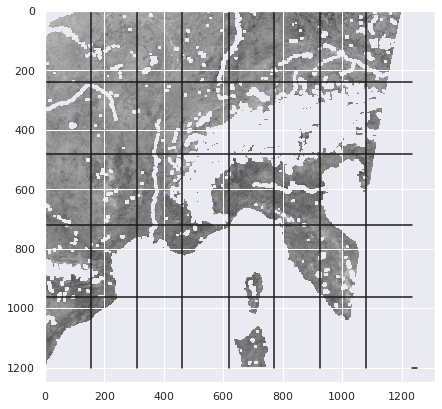

In [31]:
# Open and show rreprojected geotiff

fig = plt.figure(figsize=(7, 7))
ds_out = gdal.Open('baci_wgs84.tif')
img_out = ds_out.GetRasterBand(1).ReadAsArray()
img_out = np.ma.array(img_out, mask = np.logical_or(img_out>1, img_out==0))
plt.imshow(img_out, vmin=0, vmax=0.6)

draw_geogrid(img_out,
             np.round(lat_max).astype(int), 
             np.round(lat_min).astype(int), 
             np.round(lon_max).astype(int), 
             np.round(lon_min).astype(int), 
             proj_out, geo_out)

Now we see an image transformed to WGS84. In this casewe can use 1D arrays of latitude and longitude

## 3. Principal Component Analisys (PCA)

This section shows a simple example of using PCA to reveal what is common in the three types of datasets

In [32]:
# ds_lst['time'][1:-3]

For PCA, clustering and classification we can use python machine learning library sklearn

In this example we use only one pixel for one year. sklearn PCA uses as input a variable X which has shape (n_samples X n_features). In our example we have time series with 49 dates for three microwave domains: optical, temperature and microwave. So we have 49 samples and 3 features.

(49, 3)


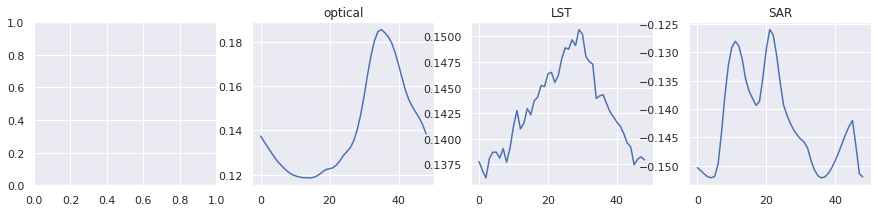

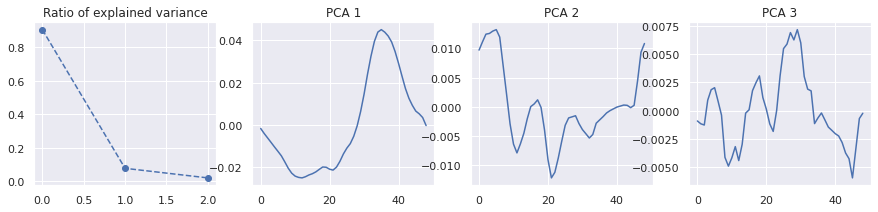

In [33]:
# create input variable X
X = np.zeros((49, 3))

# We have data with quite different scales so doing normalization is essential
X[:,0] = prep.normalize([rho])
X[:,1] = prep.normalize([lst[1:-3]])
X[:,2] = prep.normalize([sar[1:-3]])

# create an instance of object PCA
pca = decomp.PCA()

# fit PCA
pca.fit(X)

# transform the data
comp = pca.transform(X)
print(comp.shape)

plt.figure(figsize=(15,3))
plt.subplot(141)

# plt.subplot(142)
# plt.plot(ds_lst['time'], lst)
# plt.subplot(143)
# plt.plot(ds['julday'], rho)
# plt.subplot(144)
# plt.plot(ds_lst['time'], sar)
tit = ['optical', 'LST', 'SAR']
for i in range(3):
    plt.subplot(1,4,i+2)
    plt.title(tit[i])
    plt.plot(X[:, i])


plt.figure(figsize=(15,3))
plt.subplot(141)
plt.title('Ratio of explained variance')
plt.plot(pca.explained_variance_ratio_, marker='o', ls='--')
for i in range(3):
    plt.subplot(1,4,i+2)
    plt.title('PCA %d' % (i+1))
    plt.plot(comp[:, i])

Define correlation function for mapping accross the axes

In [34]:
def corrfunc(x, y, **kws):
    """
    Correlation function
    
    Parameters
    ----------
    x: x-variable for regression
    y: y-variable    
    """
    s, i, r, p, sd = stats.linregress(x, y)
    ax = plt.gca()
    ax.annotate("$r^2$ = {:.2f}\n y={:.2f}x+{:.2f}".format(r, s, i),
                xy=(.05, .75), xycoords=ax.transAxes, fontsize=14)

Do PCA and plot correlation matrix

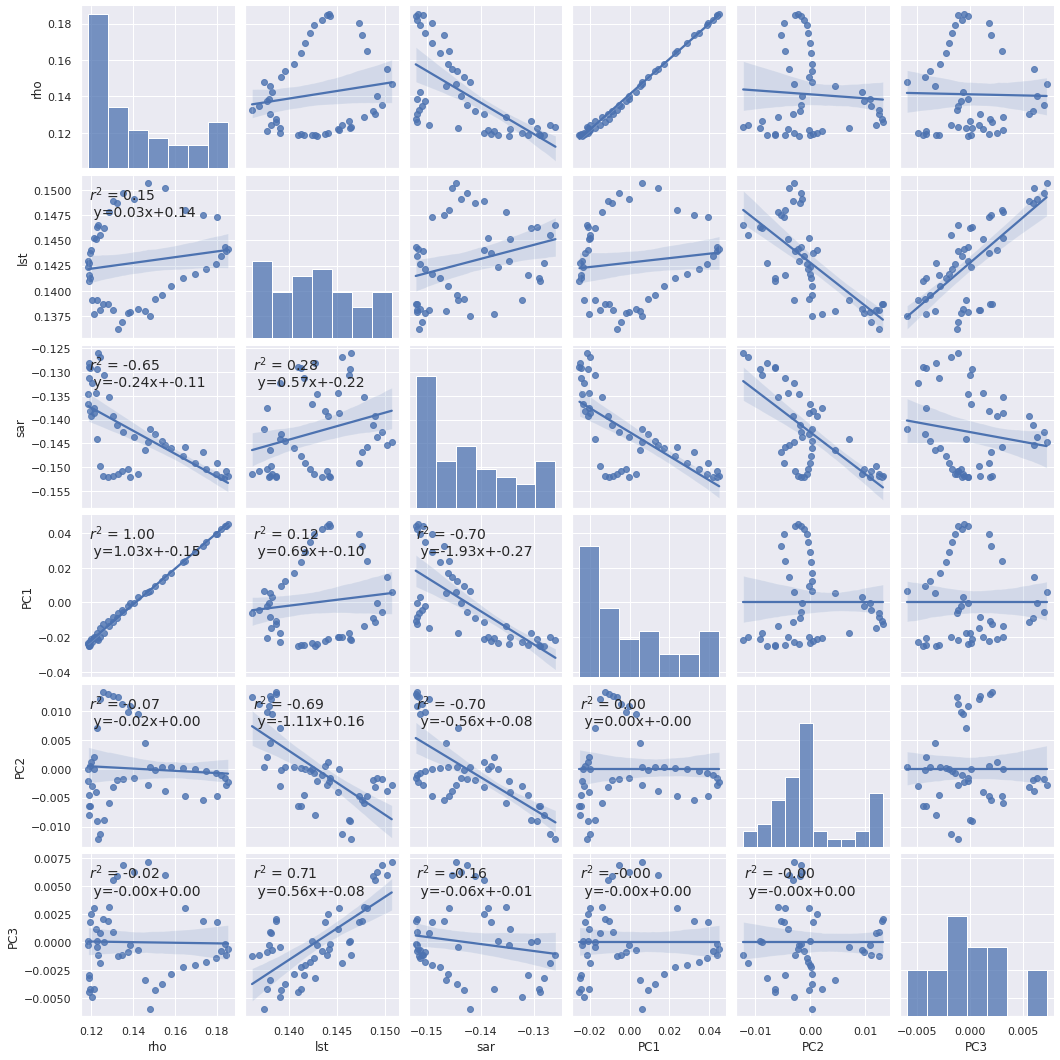

In [35]:
d = {'rho': X[:,0], 'lst': X[:,1], 'sar': X[:, 2],\
     'PC1': comp[:,0], 'PC2': comp[:,1], 'PC3': comp[:,2]}
# make pandas data frame which is special tabular representation of data
df = pd.DataFrame(data=d)
# use seaborn library to plot pairwise relationships in data
g = sns.pairplot(df, kind='reg')
# map correlation coeeficients. I.e. print r2 in corresponding plots
g.map_lower(corrfunc)
# sns.plt.show()

So we see that the first principal component explains about 80% of variance and mostly related to backscatter abd NIR reflectance.
<br> <br>
Sklearn also has other types of PCA: Incremental PCA, Kernel PCA, etc.

## 4. Clustering

Let's use the sklearn library for clustering of our data

In [36]:
# Let's open Sentinel-1 ascending orbit backscatter
ds_sar_asc = nc.Dataset('/neodc/baci_ssv/data/v1.0/regional_sites/13_europe/sar/sentinel-1_ascending_h18v04_2015_7day_vv.nc')

In order to increse speed we make a subset from the images

In [37]:
img_red = ds['reflectance/refl_b1'][0, 800:900, 1000:1200].data
img_nir = ds['reflectance/refl_b2'][0, 800:900, 1000:1200].data
img_lst = ds_lst['lst'][0, 800:900, 1000:1200].data
img_sar = ds_sar['bs'][0, 800:900, 1000:1200]
img_sar_asc = ds_sar_asc['bs'][0, 800:900, 1000:1200]

[-24.742773   -24.737427   -24.6992     ...  -0.45411164  -0.27370855
   1.7606368 ]


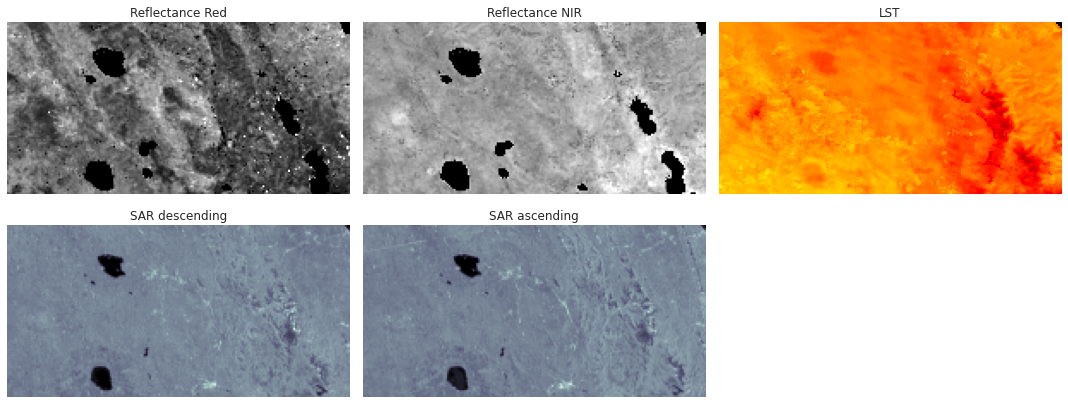

In [38]:
# Assign zero to no-data pixels
img_red[img_red > 1] = 0
img_nir[img_nir > 1] = 0
img_lst[img_lst > 1000] = 0

myimage = np.unique(img_sar)

print(myimage)

fig = plt.figure(figsize=(15, 6))

ax=plt.subplot(231)
plt.title('Reflectance Red')
ax.imshow(img_red, vmin=0, vmax=0.2, cmap=plt.set_cmap('gray'))
plt.axis('off')

ax=plt.subplot(232)
plt.title('Reflectance NIR')
ax.imshow(img_nir, vmin=0, vmax=0.5, cmap=plt.set_cmap('gray'))
plt.axis('off')

ax=plt.subplot(233)
plt.title('LST')
ax.imshow(img_lst, vmin=260, vmax=300, cmap=plt.set_cmap('hot'))
plt.axis('off')

ax = plt.subplot(234)
plt.title('SAR descending')
ax.imshow(img_sar, vmin=-23, vmax=2, cmap=plt.set_cmap('bone'))
plt.axis('off')

ax = plt.subplot(235)
plt.title('SAR ascending')
ax.imshow(img_sar_asc, vmin=-23, vmax=2, cmap=plt.set_cmap('bone'))
plt.axis('off')

fig.tight_layout()

Here we use popular clustering method K-means

In [39]:
def do_clust(Ximg):
    """
    Do clustering and plot the results
    
    Parameters
    ----------
    Ximg: array
        an array of input values (n_samples X n_features)
    """
    
    # Initialize the KMeans object and fit the data
    kmeans = KMeans(n_clusters=5, random_state=0).fit(Ximg)
    # Predict clusters
    km = kmeans.predict(Ximg)
    # Reshape array of clusters to originl size of image
    img_c = np.reshape(km, (img_red.shape[0], img_red.shape[1]))
    # Show results
    im = plt.imshow(img_c, cmap=plt.get_cmap('tab10', 5))
    plt.colorbar(ticks=range(5), label='Clusters', fraction=0.023, pad=0.03)

### 4.1 Red and NIR
Firstly we are going to use only optical data from red and NIR bands

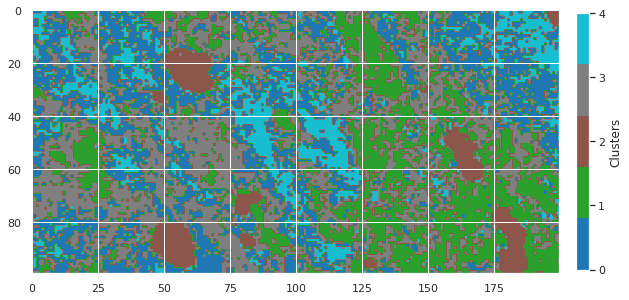

In [40]:
# Array of input values with shape n_samples x n_features
Ximg = np.zeros((img_red.shape[0] * img_red.shape[1], 2))

# We have data with quite different scales so doing normalization is essential
Ximg[:, 0] = prep.normalize([img_red.flatten()])
Ximg[:, 1] = prep.normalize([img_nir.flatten()])

plt.figure(figsize=(10, 5))
do_clust(Ximg)

### 4.2 Red, NIR and LST
On next step let's add temperature for the same date as a new feature

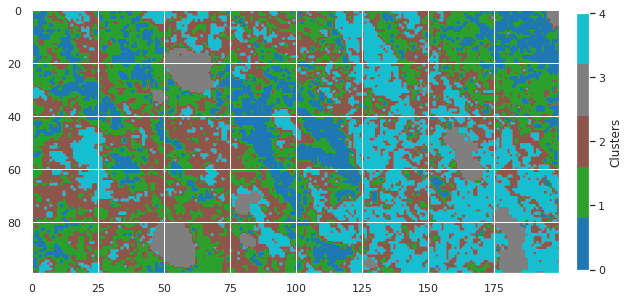

In [41]:
Ximg = np.zeros((img_red.shape[0] * img_red.shape[1], 3))

# We have data with quite different scales so doing normalization is essential
Ximg[:, 0] = prep.normalize([img_red.flatten()])
Ximg[:, 1] = prep.normalize([img_nir.flatten()])
Ximg[:, 2] = prep.normalize([img_lst.flatten()])

plt.figure(figsize=(10, 5))
do_clust(Ximg)

In the results of clusterization with data of reflectance and LST we can cleary see some lakes. 

### 4.3 Red, NIR, LST and micowave
Add SAR data

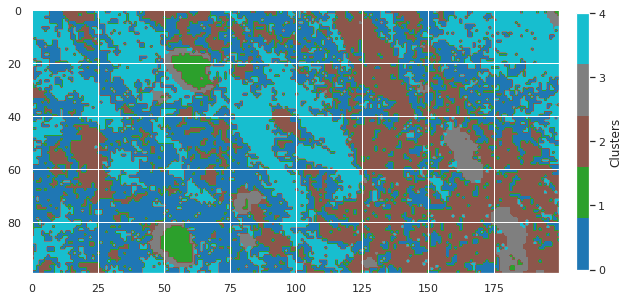

In [42]:
Ximg = np.zeros((img_red.shape[0] * img_red.shape[1], 5))

# We have data with quite different scales so doing normalization is essential
Ximg[:, 0] = prep.normalize([img_red.flatten()])
Ximg[:, 1] = prep.normalize([img_nir.flatten()])
Ximg[:, 2] = prep.normalize([img_lst.flatten()])
Ximg[:, 3] = prep.normalize([img_sar.flatten()])
Ximg[:, 4] = prep.normalize([img_sar_asc.flatten()])

plt.figure(figsize=(10, 5))
do_clust(Ximg)

The new information that have been added to results is separation of lakes with shallow waters (right hand side of the image) and more deep waters (left hand side). This kind of information can't be detected by optical data. At the same time we can see some patterns related vegetation which can't be clearly seen by a microwave sensor.
